---
## Note from the Teachers:
We added a header with information about your project. 
This is useful since we want to keep a database of all the cool projects participants have made during the courses.
We will save the code in our database and host on github a page to show all the projects. Therefore it is more practical to add some information in the header of each notebook.
Thanks a lot for the understanding and for taking care of it.

You can delete this cell if you want

---

# Project Name (replace with your project name)
Project description (replace with your project description, you can use the same from the `INFO.md` file.

### Project Repo 
link (replace if you have your own repo, otherwise delete)

## Participants:
Please list here all the participants alongside with any information you may want to be visible. This will be hosted on a opencampus.sh repository, so if you want to keep a connection to your github user include this information here. 

### Course and Semester
Add here in which course and in which semester it was done.

### License
If you are releasing the software under some certain license, you can mention it and also include the `LICENSE.md` file in the folder

---

In [444]:
# Here you can start your code! Thanks

In [445]:
pip install -q tf-models-official


In [446]:
#!pip install bert-tensorflow

In [447]:
!pip install tensorflow-text

In [448]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import csv
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import regularizers
import tensorflow.keras.utils as ku
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer

#import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors


import nltk 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 

import tensorflow as tf
import random

import tensorflow_text as text 

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [449]:
#In case of Google Colab run this:
#from google.colab import files
#uploaded = files.upload()

In [450]:
import pandas as pd
url = 'https://nc.rootnix.de/s/KS7Hkn8Cw4mdCMm/download/data_MailsAndPC_UPDATE.csv'
azubi_df = pd.read_csv(url,index_col=0,parse_dates=[0])

In [451]:
#import io
#azubi_df = pd.read_csv(io.BytesIO(uploaded['data_MailsAndPC.csv']))

In [452]:
#Global Hyperparameters
vocab_size = 3000
embedding_dim = 32
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"



In [453]:
executionType = 1

In [454]:
#In case of local github export run this:
#DATA_FOLDER = './../data'
#AZUBI_DATA = 'data_MailsAndPC.csv'
#AZUBI_DATA_CLEANED = 'data_MailsAndPC_cleaned.csv'
#azubi_df = pd.read_csv(os.path.join(DATA_FOLDER, AZUBI_DATA))

# Data Preparation


## Data Preparation Functions

In [455]:
def selectColumns(azubi_df, mail, item):

  azubi_df_selected_columns = azubi_df[[mail,item]]

  return azubi_df_selected_columns

In [456]:
def cleanupDataframe(azubi_df, mail, item):
    #Remove unneccesary columns
    #azubi_df = azubi_df.drop(columns=['Unnamed: 0', 'id'])
    #Remove "cr". Assumption made, that there are no real words containing cr in the mails.
    azubi_df["S1_mail"] = azubi_df["S1_mail"].str.replace("cr", " ")
    azubi_df["S2_mail"] = azubi_df["S2_mail"].str.replace("cr", " ")
    azubi_df["S3_mail"] = azubi_df["S3_mail"].str.replace("cr", " ")
    
    azubi_df = selectColumns(azubi_df, mail, item)
    #Drop NA rows to only have full datasets
    azubi_df = azubi_df.dropna()
    #Select all rows without '99' | ~ inverts the operator
    dropThisNumber = 99
    azubi_df = azubi_df[~azubi_df.eq(dropThisNumber).any(1)]
    #Select all rows without '6' | ~ inverts the operator
    #dropThisNumber = 6
    #azubi_df = azubi_df[~azubi_df.eq(dropThisNumber).any(1)]
    #Reset the index of the Dataframe
    azubi_df = azubi_df.reset_index(drop=True)
    return azubi_df

In [457]:
def trainDevTestSplit_sklearn(X, Y, testSize, randomSeed, stratify):
  #Splits by test size into Train / Dev
  #Splits dev then 50/50 into dev and Test

  if (stratify == True):
    xTrain, xDev, yTrain, yDev = train_test_split(X, Y, test_size=testSize,stratify = Y, random_state=randomSeed)
  else:
    xTrain, xDev, yTrain, yDev = train_test_split(X, Y, test_size=testSize, random_state=randomSeed)

  xTest = xDev[:len(xDev)//2]
  yTest = yDev[:len(yDev)//2]
  
  xDev = xDev[len(xDev)//2:]
  yDev = yDev[len(yDev)//2:]
  #xDev, yDev, xTest, yTest = train_test_split(xDev, yDev, test_size =0.5, random_state = randomSeed)

  return xTrain, yTrain, xDev, yDev, xTest, yTest

In [458]:
def tokenizeData(vocab_size, oov_tok, train_sentences, max_length, padding_type, trunc_type):
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_sentences)
   
    word_index = tokenizer.word_index
    vocab_size=len(word_index)

    print("Word Index: \n")
    print(word_index)
    
    sequences = tokenizer.texts_to_sequences(train_sentences)

    print("Sequences: \n")
    print(sequences)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    return padded

In [459]:
def oneHotEncodePreSplit(yTrain, removeZeros):
  #a = np.array([1, 0, 3])
  #yTrain = yTrain.astype(int)
  
  print("Unique Values:")
  print(np.unique(yTrain))
  print("\n")
  yTrainOneHot = tf.keras.utils.to_categorical(yTrain)
  print("Classes before removing zeros:")
  print(yTrainOneHot)
  print(yTrainOneHot.sum(axis=0))
  print("\n")

  if (removeZeros == True):
    yTrainOneHot = yTrainOneHot[:,~np.all(yTrainOneHot == 0, axis = 0)]
  print("Classes after removing zeros:")
  print(yTrainOneHot)
  print(yTrainOneHot.sum(axis=0))
  print("\n")

  return yTrainOneHot

In [460]:
def makeListSelectedColumns(azubi_df, mail, score):
  #Sentence S1
  mailSentences = azubi_df[mail].tolist()
  #Labels S1
  scoreLabels = azubi_df[score].tolist()

  return mailSentences, scoreLabels

## Stop Words


In [461]:
#stopwords
def removeStopWordsSelectedColumns(azubi_df_cleaned, mail):

  nltk.download('punkt')
  nltk.download('stopwords')

  stemmer = SnowballStemmer("german")
  stop_words = set(stopwords.words("german"))
  #stop_words.add('Meier')
  #stop_words.add('Neumann')

  azubi_df_cleaned_no_stopwords = pd.DataFrame()

  pat = r'\b(?:{})\b'.format('|'.join(stop_words))
  azubi_df_cleaned[mail] = azubi_df_cleaned[mail].str.replace(pat, '')
  azubi_df_cleaned[mail] = azubi_df_cleaned[mail].str.replace(r'\s+', ' ')

  return azubi_df_cleaned

#allerdings Wörter wie "nicht" enthalten

## Show Model Performance

In [462]:
def showModelPerformance(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title('Random Forest Model')
    plt.legend([string, 'val_'+string])
    plt.show()

    return

## Execute Data Preparation



## Combine all mails for a4s2_combined_i2b score



In [463]:
#Create new dataframe
azubi_df_mails_and_scored_combined = pd.DataFrame(columns=["Mails_Combined", "a4s_combined_i2b"])
#Use cleanup function to select the correct data from the dataframe
azubi_df_mail1 = cleanupDataframe(azubi_df, 'S1_mail', 'a4s1i2b')
azubi_df_mail2 = cleanupDataframe(azubi_df, 'S2_mail', 'a4s2i2b')
azubi_df_mail3 = cleanupDataframe(azubi_df, 'S3_mail', 'a4s3i2b')

In [464]:
#Rename the columns
azubi_df_mail1_renamed = azubi_df_mail1.rename(columns={"S1_mail": "Mails_Combined", "a4s1i2b": "a4s_combined_i2b"})
azubi_df_mail2_renamed = azubi_df_mail2.rename(columns={"S2_mail": "Mails_Combined", "a4s2i2b": "a4s_combined_i2b"})
azubi_df_mail3_renamed = azubi_df_mail3.rename(columns={"S3_mail": "Mails_Combined", "a4s3i2b": "a4s_combined_i2b"})

In [465]:
#Append the renamed columns, ignore index so it is appended at the end
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined.append(azubi_df_mail1_renamed, ignore_index=True)
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined.append(azubi_df_mail2_renamed, ignore_index=True)
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined.append(azubi_df_mail3_renamed, ignore_index=True)

In [466]:
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined[azubi_df_mails_and_scored_combined.a4s_combined_i2b != 9.0]
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined[azubi_df_mails_and_scored_combined.a4s_combined_i2b != 2.0]
azubi_df_mails_and_scored_combined = azubi_df_mails_and_scored_combined.reset_index()

In [467]:
azubi_df_mails_and_scored_combined['Mails_Combined'][2]

'bitte kommen Sie rüber und erklären mir es selbst'

In [468]:
azubi_df_mails_and_scored_combined['a4s_combined_i2b']

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
2082    0.0
2083    1.0
2084    1.0
2085    1.0
2086    1.0
Name: a4s_combined_i2b, Length: 2087, dtype: float64

In [469]:
azubi_df_mails_and_scored_combined

,index,Mails_Combined,a4s_combined_i2b
0,0,"Hallo Fr. Meier, leider konnte ich die von Ih...",1.0
1,1,Ihre Antwort... Der EP Plan weicht viel zuse...,1.0
2,2,bitte kommen Sie rüber und erklären mir es selbst,0.0
3,3,"Sehr geehrte Frau Meier, leider konnte Ich Ih...",1.0
4,5,"Hallo Frau Meier, das Controlling hat für das...",1.0
...,...,...,...
2082,2135,"Hallo Herr Neumann, gerne würde ich Ihnen mei...",0.0
2083,2136,"Hallo Herr Neumann, leider konnte ich aus der...",1.0
2084,2137,"Ihre Antwort... Guten Tag Herr Neumann, leid...",1.0
2085,2138,"Guten Tag Herr Neumann, hier die beiden Liste...",1.0


### Selected Columns Scores

In [470]:
def prepareDataSelectedColumns(azubi_df, mail, score, doCleanup, paddedOutput, word2vec): 
  #Prepare the data
  if doCleanup == True:
    azubi_df_cleaned = cleanupDataframe(azubi_df, mail, score)
  else:
    azubi_df_cleaned = azubi_df
  #print(azubi_df_cleaned[score][9])

  #Remove Stop words
  #azubi_df_cleaned_no_stopwords = removeStopWordsSelectedColumns(azubi_df_cleaned, mail)
  mailSentences, scoreLabels = makeListSelectedColumns(azubi_df_cleaned, mail, score)
  print(len(mailSentences))
  print(len(scoreLabels))

  yTrainOneHot = oneHotEncodePreSplit(np.array(scoreLabels), True)

  if paddedOutput == True and word2vec == False:
    print("Padded Output True")
    padded = tokenizeData(vocab_size, oov_tok, mailSentences, max_length, padding_type, trunc_type)
    xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(padded, yTrainOneHot, 0.1, 42, False)
  elif word2vec == True and paddedOutput == False:
    padded = word2vecTokenizer(mailSentences, glove_vectors)
    print(padded)
  else:
    xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(mailSentences, yTrainOneHot, 0.4, 42, False)

  xTrainArray = xTrain#np.array(xTrain)
  yTrainArray = yTrain#np.array(yTrain)


  xValArray = xVal#np.array(xVal)
  yValArray = yVal#np.array(yVal)


  xTestArray = xTest#np.array(xTest)
  yTestArray = yTest#np.array(yTest)
  print(len(xTrainArray))
  print(len(yTrainArray))
  print(len(xValArray))
  print(len(yValArray))
  print(len(xTestArray))
  print(len(yTestArray))


  return xTrainArray, yTrainArray, xValArray, yValArray, xTestArray, yTestArray, azubi_df_cleaned


In [471]:
#xTrainArray

In [472]:
xTrainArray, yTrainArray, xValArray, yValArray, xTestArray, yTestArray, azubi_df_cleaned_no_stopwords = prepareDataSelectedColumns(azubi_df_mails_and_scored_combined, 'Mails_Combined', 'a4s_combined_i2b', False, False, False)

2087
2087
Unique Values:
[0. 1.]


Classes before removing zeros:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[ 146. 1941.]


Classes after removing zeros:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[ 146. 1941.]


1252
1252
418
418
417
417


In [473]:
xTrainArray2, yTrainArray2, xValArray2, yValArray2, xTestArray2, yTestArray2, azubi_df_cleaned_no_stopwords2 = prepareDataSelectedColumns(azubi_df, 'S2_mail', 'a4s2i2b', True,  False, False)

725
725
Unique Values:
[0. 1. 2. 9.]


Classes before removing zeros:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[ 38. 666.   1.   0.   0.   0.   0.   0.   0.  20.]


Classes after removing zeros:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[ 38. 666.   1.  20.]


435
435
145
145
145
145


In [474]:
#only for a4s2i2b
#yTrainArray = np.delete(yTrainArray, 2, 1)
#yTrainArray = np.delete(yTrainArray, 2, 1)

#yValArray = np.delete(yValArray, 2, 1)
#yValArray = np.delete(yValArray, 2, 1)

#yTestArray = np.delete(yTestArray, 2, 1)
#yTestArray = np.delete(yTestArray, 2, 1)

In [475]:
yTrainArray.sum(axis=0)

array([  87., 1165.], dtype=float32)

In [476]:
yValArray.sum(axis=0)

array([ 33., 385.], dtype=float32)

In [477]:
yTestArray.sum(axis=0)

array([ 26., 391.], dtype=float32)

In [478]:
pd.set_option('display.max_rows', azubi_df.shape[0]+1)
azubi_df['a4s1i2b'].unique()

array([ 1.,  0.,  9., nan])

### Sum Scores Data

In [479]:
def prepareDataSumScores(azubi_df, mail, score, paddedOutput): 
  #Prepare the data
  azubi_df_cleaned = cleanupDataframe(azubi_df)
  print(azubi_df_cleaned['S1_mail'][5])

  #Remove Stop words
  azubi_df_cleaned_no_stopwords = removeStopWords(azubi_df_cleaned)

  azubi_df_list , s1MailSentences, s1MailA3Labels, s1MailA4Labels, s2MailSentences, s2MailA3Labels, s2MailA4Labels, s3MailSentences, s3MailA3Labels, s3MailA4Labels = makeList(azubi_df_cleaned_no_stopwords)

  if (mail == 'S1'):
    if (score == 'A3'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s1MailA3Labels), False)
    elif (score == 'A4'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s1MailA4Labels), False)
    
    if (paddedOutput == True):
      padded = tokenizeData(vocab_size, oov_tok, s1MailSentences, max_length, padding_type, trunc_type)
      xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(padded, yTrainOneHot, 0.1, 42, False)
    elif (paddedOutput == False):
      xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(s1MailSentences, yTrainOneHot, 0.4, 42, False)
  elif (mail == 'S2'):
    if (score == 'A3'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s2MailA3Labels), False)
    elif (score == 'A4'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s2MailA4Labels), False)
    
    if (paddedOutput == True):
      padded = tokenizeData(vocab_size, oov_tok, s2MailSentences, max_length, padding_type, trunc_type)
      xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(padded, yTrainOneHot, 0.1, 42, False)
    elif (paddedOutput == False):
      xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(s2MailSentences, yTrainOneHot, 0.4, 42, False)
    
  elif (mail == 'S3'):
    if (score == 'A3'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s3MailA3Labels), False)
    elif (score == 'A4'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s3MailA4Labels), False)

    if (paddedOutput == True):
      padded = tokenizeData(vocab_size, oov_tok, s3MailSentences, max_length, padding_type, trunc_type)
      xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(padded, yTrainOneHot, 0.1, 42, False)
    elif (paddedOutput == False):
      xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(s3MailSentences, yTrainOneHot, 0.4, 42, False)

  else:
    print('Select S1, S2 or S3 as mail and A3 or A4 as score')

    
  


  #train_padded = tokenizeData(vocab_size, oov_tok, xTrain, max_length, padding_type, trunc_type)
  #validation_padded = tokenizeData_val(xVal, max_length, padding_type)
  #test_padded = tokenizeData_val(xTest, max_length, padding_type)

  train_padded = np.array(xTrain)
  yTrain = np.array(yTrain)
  #yTrainOneHot = yTrain
  #yTrain = np.reshape(yTrain, (yTrain.shape[0], 1))

  validation_padded = np.array(xVal)
  yVal = np.array(yVal)
  #yValOneHot = yVal
  #yVal = np.reshape(yVal, (yVal.shape[0], 1))

  test_padded = np.array(xTest)
  yTest = np.array(yTest)
  #yTestOneHot = yTest

  return train_padded, validation_padded, test_padded, yTrain, yVal, yTest

  #yTest = np.reshape(yTest, (yTest.shape[0], 1))

  #yTrainOneHot, yValOneHot, yTestOneHot, yTrainOneHotNoZeros, yValOneHotNoZeros, yTestOneHotNoZeros = oneHotEncodeAlternative(yTrain, yVal, yTest, False)

In [480]:
#train_padded_sum, validation_padded_sum, test_padded_sum, yTrain_padded_sum, yVal_padded_sum, yTest_padded_sum = prepareDataSumScores(azubi_df, 'S1', 'A4', True)

In [481]:
#train_sum, validation_sum, test_sum, yTrain_sum, yVal_sum, yTest_sum = prepareDataSumScores(azubi_df, 'S1', 'A4', False)

### Currently not needed

In [482]:
if (executionType == 2):    
  #Prepare the data
  azubi_df_cleaned = cleanupDataframeGetSingleClass(azubi_df, 0, 'a3s1')

  #Remove Stop words
  azubi_df_cleaned_no_stopwords = removeStopWords(azubi_df_cleaned)

  azubi_df_list , s1MailSentences, s1MailA3Labels, s1MailA4Labels, s2MailSentences, s2MailA3Labels, s2MailA4Labels, s3MailSentences, s3MailA3Labels, s3MailA4Labels = makeList(azubi_df_cleaned_no_stopwords)
  xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(s1MailSentences, s1MailA3Labels, 0.4, 42, True)

  train_padded = tokenizeData(vocab_size, oov_tok, xTrain, max_length, padding_type, trunc_type)
  validation_padded = tokenizeData_val(xVal, max_length, padding_type)
  test_padded = tokenizeData_val(xTest, max_length, padding_type)

  train_padded = np.array(train_padded)
  yTrain = np.array(yTrain)
  yTrain = np.reshape(yTrain, (yTrain.shape[0], 1))

  validation_padded = np.array(validation_padded)
  yVal = np.array(yVal)
  yVal = np.reshape(yVal, (yVal.shape[0], 1))

  test_padded = np.array(test_padded)
  yTest = np.array(yTest)
  yTest = np.reshape(yTest, (yTest.shape[0], 1))

  yTrainOneHot,yValOneHot,yTestOneHot = oneHotEncode(yTrain, yVal, yTest, True)

### Single scores data

In [483]:
def prepareDataSingleScores(azubi_df, mail, score):
  #Prepare the data
  azubi_df_cleaned = cleanupDataframe(azubi_df)

  #Remove Stop words
  azubi_df_cleaned_no_stopwords = removeStopWords(azubi_df_cleaned)

  azubi_df_list , s1MailSentences, s1Maila3s1i1a, s1Maila3s1i1b, s1Maila3s1i2a, s1Maila3s1i2b, s1Maila3s1i2c = makeListSubscores(azubi_df_cleaned_no_stopwords)
  xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(s1MailSentences, s1Maila3s1i1a, 0.4, 42, False)

  if (mail == 'S1'):
    if (score == 'a3s1i1a'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s1Maila3s1i1a), True)
    elif (score == 'a3s1i1b'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s1Maila3s1i1b), True)
    elif (score == 'a3s1i2a'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s1Maila3s1i2a), True)
    elif (score == 'a3s1i2b'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s1Maila3s1i2b), True)
    elif (score == 'a3s1i2c'):
      yTrainOneHot,yTrainOneHotNoZeros = oneHotEncodePreSplit(np.array(s1Maila3s1i2c), True)
  
    xTrain, yTrain, xVal, yVal, xTest, yTest = trainDevTestSplit_sklearn(s1MailSentences, yTrainOneHotNoZeros, 0.4, 42, False)

  train_padded = tokenizeData(vocab_size, oov_tok, xTrain, max_length, padding_type, trunc_type)
  validation_padded = tokenizeData_val(xVal, max_length, padding_type)
  test_padded = tokenizeData_val(xTest, max_length, padding_type)

  train_padded = np.array(train_padded)
  yTrain = np.array(yTrain)
  #yTrain = np.reshape(yTrain, (yTrain.shape[0], 1))

  validation_padded = np.array(validation_padded)
  yVal = np.array(yVal)
  #yVal = np.reshape(yVal, (yVal.shape[0], 1))

  test_padded = np.array(test_padded)
  yTest = np.array(yTest)
  #yTest = np.reshape(yTest, (yTest.shape[0], 1))

  #yTrainOneHot, yValOneHot, yTestOneHot, yTrainOneHotNoZeros, yValOneHotNoZeros, yTestOneHotNoZeros = oneHotEncodeAlternative(yTrain, yVal, yTest)

  return train_padded, validation_padded, test_padded, yTrain, yVal, yTest, xTrain, yTrain, xVal

In [484]:
#train_padded_single, validation_padded_single, test_padded_single, yTrain_single, yVal_single, yTest_single, xTrain_single, yTrain_single, xVal_single = prepareDataSingleScores(azubi_df, 'S1', 'a3s1i1b')

# Transfer Learning


# preparation

Sources i used to create and understand word2vec:


In [485]:
#Word2vec approach. We followed a mix out of several turoials:
#    https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html
#    https://discuss.huggingface.co/t/generate-raw-word-embeddings-using-transformer-models-like-bert-for-downstream-process/2958
#    https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
#    https://phdstatsphys.wordpress.com/2018/12/27/word2vec-how-to-train-and-update-it/

Import, especially gensin and gensim.downloader for word2vec

In [486]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
!pip install lime
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
#!pip install transformer
#from transformer

As always, take a look at the data first to ensure everything is all right

In [487]:
azubi_df_mails_and_scored_combined.sample(10)

,index,Mails_Combined,a4s_combined_i2b
239,248,"Sehr geehrter Frau Meier, ich möchte Sie nic...",1.0
747,770,"Hallo Herr Neumann, die bearbeitete Datei ist...",1.0
1947,2000,"Hallo Herr Neumann, im Anhang befinden sich d...",1.0
586,604,"Servus, Hier die Tabelle. Gruß der Boss",0.0
499,515,"Hallo Frau Meier, leider komme ich nicht weit...",1.0
773,796,"Hallo Herr Neumann, in Angang finden Sie die ...",1.0
426,439,"Hallo Frau Meier, anbei sende ich Ihnen die ü...",1.0
1869,1922,"Hallo Neumi , alles klar du? Im Anhang hab i...",0.0
1007,1040,"Hallo Herr Neumann, danke, das Sie mich in di...",1.0
381,393,"Sehr geehrte Frau Meier, es tut mir wirklich ...",1.0


And we also want to make sure our data set is balanced. Which is not the case. Thus, we include weights later in the model.

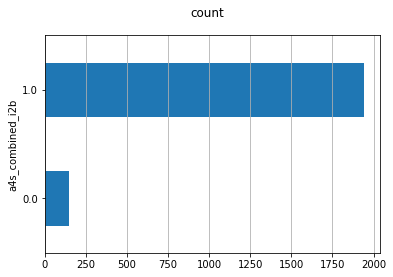

In [488]:
fig, ax = plt.subplots()
fig.suptitle("count", fontsize=12)
azubi_df_mails_and_scored_combined["a4s_combined_i2b"].reset_index().groupby("a4s_combined_i2b").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

And we split the data into train and test set. A validation set will be splitted seperately.

In [489]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(azubi_df_cleaned_no_stopwords, test_size=0.3)## get target
y_train = dtf_train["a4s_combined_i2b"].values
y_test = dtf_test["a4s_combined_i2b"].values

# word2vec

Here we start with word2vec and this might take some time so here are some facts about word2vec: 

The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications.

(more info: https://code.google.com/archive/p/word2vec/)

In [490]:
# download word2vec takes 10 min
#we could use this word2vec pretrained model by using this line of code, but instead we wanted to make a word2vec embedding with our own corpus, because word2vec wasn't trained with business mails
# nlp = gensim_api.load("word2vec-google-news-300") 

Lets use word2vec with our corpus. We define unigrams here to determine polite word sequences. The functions we use are part of gensim, so this is rather easy.

In [491]:
corpus =  dtf_train["Mails_Combined"]
## create list of lists of unigrams (#Sehr)
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)
## detect bigrams (#Sehr geehrter) and trigrams (#Sehr geehrte:r Herr:Frau)
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)



This is crucial now. We determine the setup to create polite word embedding vectors.
- target size = of the word vectors
- window = is the maximum distance between the current and predicted word within a mail
- sg = training algorithm we  use skip-grams (sg=1) as it was used in the tutorial and this should also in general lead to the best results in most cases
- iter = number of iterations

In [492]:
#word2vec setup
#play with size=300, window = 8? mean lenght?
# target size, mean length window of distance, and sgram 1: has proven robust 
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=5, min_count=3, sg=1, iter=30)



How is our word embedding shaped? It is a 1 dimensional 50 array. Lets take a closer look:

In [493]:
word = "freundlichen"
nlp[word].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(300,)

And this is actually the vector space. Cool Hmm? Test it for yourself if you like to play with...

In [494]:
nlp[word]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.3240863 ,  0.4785589 , -0.11547601,  0.7307972 , -0.28708264,
        0.0210297 ,  0.05366279, -0.04049633,  0.40896362, -0.00374104,
       -0.1381456 ,  0.38668117, -0.11121905, -0.00773707,  0.30516794,
       -0.18702917, -0.0505514 ,  0.05308989, -0.05575079, -0.01063831,
        0.10554952, -0.12481941,  0.12057262,  0.59855044, -0.1406521 ,
       -0.1806016 ,  0.5589563 , -0.26697055, -0.3921832 ,  0.08528683,
        0.00732548, -0.6114965 , -0.15808375,  0.26690254, -0.04392993,
        0.41026178,  0.07223306,  0.07307627, -0.49127278,  0.03682881,
        0.0242748 , -0.07810225,  0.1194987 , -0.34858134, -0.4299004 ,
        0.01461215,  0.3064066 , -0.07555825, -0.11133344,  0.03829439,
       -0.4397034 , -0.20938534,  0.07495375, -0.3099312 ,  0.02627572,
        0.00651161,  0.10936158,  0.35466903, -0.20649172,  0.20769148,
        0.16942982,  0.1983963 ,  0.04368992,  0.25675553, -0.10875254,
       -0.26558006,  0.14257434, -0.03736839,  0.04191426, -0.01

We can even print this in in 3d space with related words...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


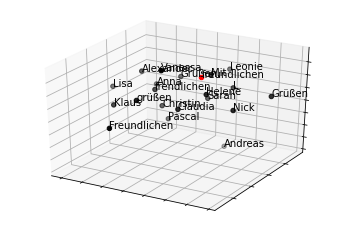

In [495]:
word = word
fig = plt.figure()## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

note: maybe we can add here a download buttom to upload these files in this cool tensorflow showcase for word embeddings
shortcoming: need to be lowercased, thus might not be appropriate to measure politeness in german, e.g. Sie vs. sie / Ihre vs ihre

Ok, lets use our created embeddings by transforming this corpus to the Word2Vec into a list of sequences using tensorflow/keras and pad.sequences.


In [496]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=200, padding="post", truncating="post") #need to think about maxlen

How does our features look like? We see here a feature map where we see that some mails contains more features (black) than others.

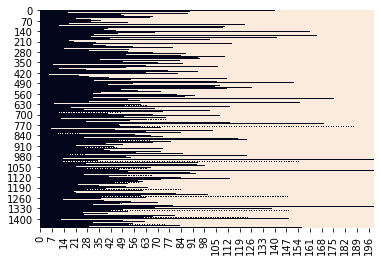

In [497]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()
#feature matrixy visual x * 120

this is optional and it throws errors when it comes to the dict, due to missing words in the dict... maybe caused by lowercased words?

In [498]:
i = 10

# list of text: ["I like this", ...]
len_txt = len(dtf_train["Mails_Combined"].iloc[i].split())
print("from: ", dtf_train["Mails_Combined"].iloc[i], "| len:", len_txt)

# sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

# vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["Mails_Combined"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", )
      #dic_vocabulary[dtf_train["Mails_Combined"].iloc[i].split()[0]]) # <---- this is the error

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:10]), "... (padding element, 0)")

from:  Guten Tag Frau Meier,  vielen Dank für Ihre Mail. In Anbetracht der kurzen Zeit habe ich stets mein Bestes gegeben Ihre Datei der  Deckugsbeitragsrechung zu bearbeiten. Leider konnte ich nicht für alle Positionen eine Erklärung finden,  weshalb die Preise teilweise stark abgewichen sind von den kalkulierten. Ich habe im Notizblock einige  Kommentare eingegeben für Positonen, wo die Preise stark abgewichen sind. Die Hauptursachen dafür  waren zunächst Eilbestellungen, Preisänderungen durch neuere Modelle und Mengenrabatte.   Freundliche Grü | len: 75
to:  [ 100  135   35   42  155  216   16   99 1043   11 1426    4  299   57
   20    2 1880  146  464  579   99  154    4 4468    7  335   28   52
    2    8   16  142  487   29 1279 1619  706    3  147  465  636 1881
   54   22   12 4469    2   20   36 4470  223 4471 4472   16 4473  510
    3  147  636 1881  194    3 4474  234  376  787 4475 2271  122 4476
 2272    5 1882  213 4477    0    0    0    0    0    0    0    0    0
    0 

We then "engineer" the same features on the test set too!

In [499]:
### do some engineering
corpus = dtf_test["Mails_Combined"]
## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    ## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=200,
             padding="post", truncating="post")

And now we create the matrix of embeddings that will be used as a weight matrix in the neural network classifier.

In [500]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


just a final check to see if everything is all right

In [501]:
word = "freundlichen"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 21 |idx
embeddings[idx]: (300,) |vector


Lets measure the inbalance to get some class_weights

In [502]:
# we need to fix our inbalanced dataset by using a balance function by sklearn
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([7.60416667, 0.53519062])

And here we define our model with an attention and embedding layer. We use an embedding layer to include our embeddings as wights, and a small RNN with two 2 LSTM layers a dense layer and an output layer with 2 neurons, and a softmax as activation function. (we use this model design, as it was sucessfully used in a similar task).

In [503]:
from tensorflow import keras

## input
x_in = layers.Input(shape=(200,))## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=200, trainable=False)(x_in)
## apply attention
#x = attention_layer(x, neurons=150)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=200, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=200, dropout=0.2,
                          return_sequences=False))(x)
#x = layers.LSTM(units=100, dropout=0.2)(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)
#y_out = layers.Dense(1, activation='sigmoid')(x)## compile
model = models.Model(x_in, y_out)

opt = keras.optimizers.Adam(lr=1e-6)
model.compile(loss='sparse_categorical_crossentropy',  # #binary_crossentropy 
              optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_42 (Embedding)     (None, 200, 300)          3322200   
_________________________________________________________________
bidirectional_84 (Bidirectio (None, 200, 400)          801600    
_________________________________________________________________
bidirectional_85 (Bidirectio (None, 400)               961600    
_________________________________________________________________
dense_73 (Dense)             (None, 64)                25664     
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 130       
Total params: 5,111,194
Trainable params: 1,788,994
Non-trainable params: 3,322,200
________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
19/19 - 7s - loss: 0.6315 - accuracy: 0.0950 - val_loss: 0.7159 - val_accuracy: 0.0993
Epoch 2/100
19/19 - 2s - loss: 0.6304 - accuracy: 0.1190 - val_loss: 0.7125 - val_accuracy: 0.1130
Epoch 3/100
19/19 - 2s - loss: 0.6303 - accuracy: 0.1558 - val_loss: 0.7090 - val_accuracy: 0.1370
Epoch 4/100
19/19 - 2s - loss: 0.6290 - accuracy: 0.1909 - val_loss: 0.7062 - val_accuracy: 0.1575
Epoch 5/100
19/19 - 2s - loss: 0.6287 - accuracy: 0.2346 - val_loss: 0.7029 - val_accuracy: 0.2123
Epoch 6/100
19/19 - 2s - loss: 0.6281 - accuracy: 0.2783 - val_loss: 0.6999 - val_accuracy: 0.2774
Epoch 7/100
19/19 - 2s - loss: 0.6269 - accuracy: 0.3416 - val_loss: 0.6968 - val_accuracy: 0.3801
Epoch 8/100
19/19 - 2s - loss: 0.6265 - accuracy: 0.4452 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 9/100
19/19 - 2s - loss: 0.6252 - accuracy: 0.5009 - val_loss: 0.6905 - val_accuracy: 0.5788
Epoch 10/100
19/19 - 2s - loss: 0.6248 - accuracy: 0.5908 - val_loss: 0.6874 - val_accuracy: 0.6438
Epoch 11/

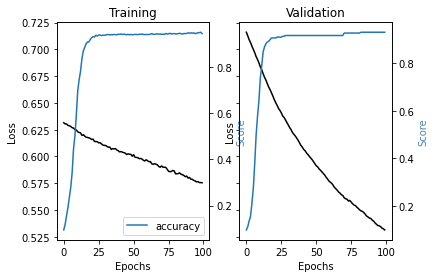

In [504]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train, y=y_train, batch_size=64, 
                     epochs=100, shuffle=True, verbose=2, 
                     validation_split=0.2, class_weight={0:7, 1:0.5}) #0:14, 1:1

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)

ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()

ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()



In [505]:
#insert chris predict model function here #need chris quick help
# my guess: this sucks. i think there are only 1's predicted

def showModelPerformance(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title('Random Forest Model')
    plt.legend([string, 'val_'+string])
    plt.show()

    return

Several problems might induce this behavior:
- maybe our dataset is to small to create our own embeddings
- maybe we made some major fails when creating embeddings or the model

anyways... lets continue with a pretrained model (BERT)

In [506]:
this is an intentional error
#it is also very crucial to restart all because the model is somehow saving its weights and does not start new

SyntaxError: ignored

# Build Models

## Fit learning rate


In [ ]:
def fitLearningRate(training_padded, training_labels,validation_padded, validation_label, vocab_size, embedding_dim, max_length, num_epochs):
  
  model = tf.keras.Sequential([
  #model design
  #tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  #tf.keras.layers.GlobalAveragePooling1D(), #fiddle #MaxPooling1D(pool_size=)
  #tf.keras.layers.Dense(16, activation='relu'), #fiddle
  #tf.keras.layers.Dense(5, activation='softmax')]) #5 scores, 5 outputs per scenario
   
  tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Conv1D(32, 5, activation='sigmoid'),
  #tf.keras.layers.MaxPooling1D(pool_size=4),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(7, activation='softmax')])
  
  #Fit the model
  #Input: compiled Model, Train and Validation Data, Batch Size and trainingEpochs
  #Return: history and model
  optimizer = tf.keras.optimizers.RMSprop(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
  
  #one hot encode
  training_labels = np.array(training_labels)
  validation_label = np.array(validation_label)
  training_labels = np.concatenate((training_labels))
  validation_label = np.concatenate((validation_label))
  training_labels = to_categorical(training_labels, 7)
  validation_label = to_categorical(validation_label, 7)

  print("xtrain")
  print(training_padded.shape)
  print("ytrain")
  print(training_labels.shape)
  print("xval")
  print(validation_padded.shape)
  print("yval")
  print(validation_label.shape)
  

  # fit network
  history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_label),callbacks=[lr_schedule], verbose=2)

  # plot history
  plt.semilogx(history.history["lr"], history.history["loss"])
  plt.show()
  #pyplot.legend()
  #pyplot.show()
  #history = compiledModel.fit(xTrain, yTrain,batch_size=512, epochs = trainingEpochs,callbacks=[lr_schedule])

  return model, history

## First approach

### Startermodel

In [ ]:
def startermodel(training_padded, training_labels,validation_padded, validation_label, vocab_size, embedding_dim, max_length, num_epochs): #weights=[embeddings_matrix], trainable=False

  model = tf.keras.Sequential([
    #model design
    #tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.GlobalAveragePooling1D(), #fiddle #MaxPooling1D(pool_size=)
    #tf.keras.layers.Dense(16, activation='relu'), #fiddle
    #tf.keras.layers.Dense(5, activation='softmax')]) #5 scores, 5 outputs per scenario
    
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv1D(32, 5, activation='sigmoid'),
    #tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax')])
    
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  
  #one hot encode
  training_labels = np.array(training_labels)
  validation_label = np.array(validation_label)
  training_labels = np.concatenate((training_labels))
  validation_label = np.concatenate((validation_label))
  training_labels = to_categorical(training_labels, 7)
  validation_label = to_categorical(validation_label, 7)

  print("xtrain")
  print(training_padded.shape)
  print("ytrain")
  print(training_labels.shape)
  print("xval")
  print(validation_padded.shape)
  print("yval")
  print(validation_label.shape)
  

  # fit network
  history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_label), verbose=2)
  
  # plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()
 
          
  return model, history

### Bidirectional

In [ ]:
def startermodelBidirectional(training_padded, training_labels,validation_padded, validation_label, vocab_size, embedding_dim, max_length, num_epochs): #weights=[embeddings_matrix], trainable=False

  model = tf.keras.Sequential([
    #model design
    #tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.GlobalAveragePooling1D(), #fiddle #MaxPooling1D(pool_size=)
    #tf.keras.layers.Dense(16, activation='relu'), #fiddle
    #tf.keras.layers.Dense(5, activation='softmax')]) #5 scores, 5 outputs per scenario
    
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv1D(32, 5, activation='sigmoid'),
    #tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(LSTM(32)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax')])
    
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  
  #one hot encode
  training_labels = np.array(training_labels)
  validation_label = np.array(validation_label)
  training_labels = np.concatenate((training_labels))
  validation_label = np.concatenate((validation_label))
  training_labels = to_categorical(training_labels, 7)
  validation_label = to_categorical(validation_label, 7)

  print("xtrain")
  print(training_padded.shape)
  print("ytrain")
  print(training_labels.shape)
  print("xval")
  print(validation_padded.shape)
  print("yval")
  print(validation_label.shape)
  

  # fit network
  history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_label), verbose=2)

  # plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()
          
  return model, history

## Experimental approaches


## Bert Model Multilingual

In [ ]:
pip install transformers

In [ ]:
from transformers import pipeline
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = TFBertModel.from_pretrained("bert-base-multilingual-cased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

In [ ]:
encoded_input

In [ ]:
pip install -q -U tensorflow-text


In [ ]:
pip install -q tf-models-official


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [ ]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

In [ ]:
azubi_df_mails_and_scored_combined

In [ ]:
import pandas as pd

class_list = ['Impolite','Polite']

#df1 = pd.read_csv('germeval2019GoldLabelsSubtask1_2.txt',sep='\t', lineterminator='\n',encoding='utf8',names=["tweet", "task1", "task2"])
#df2 = pd.read_csv('germeval2019.training_subtask1_2_korrigiert.txt',sep='\t', lineterminator='\n',encoding='utf8',names=["tweet", "task1", "task2"])

#df = pd.concat([df1,df2])
#df['task2'] = df['task2'].str.replace('\r', "")
#df['pred_class'] = df.apply(lambda x:  class_list.index(x['task2']),axis=1)


df =azubi_df_mails_and_scored_combined #df[['tweet','pred_class']]

print(df.shape)
df.head()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.10)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

In [ ]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 10}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "distilbert-base-german-cased",
    #num_labels=1,
    args=train_args
)


In [ ]:
model

In [ ]:
xTrainArray, yTrainArray, xValArray, yValArray, xTestArray, yTestArray

In [ ]:
type(yTrainArray)

In [ ]:
# Creating pandas dataframe from numpy array
train_data = pd.DataFrame({'Mails_Combined': xTrainArray, 'a4s_combined_i2b': yTrainArray[:,1]})
val_data = pd.DataFrame({'Mails_Combined': xValArray, 'a4s_combined_i2b': yValArray[:,1]})
test_data = pd.DataFrame({'Mails_Combined': xTestArray, 'a4s_combined_i2b': yTestArray[:,1]})


In [ ]:
test_data.head()

In [ ]:
# Train the model
model.train_model(train_df=train_data, eval_df=val_data)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(val_data, f1=f1_score, acc=accuracy_score)

result

In [ ]:
model_outputs

In [ ]:
class_list = ['Impolite','Polite']

for i in range(len(test_data)):

  test_tweet = test_data['Mails_Combined'][i]
  predictions, raw_outputs = model.predict([test_tweet])

  if predictions[0] != 1:
    print(i)
    print(raw_outputs)
    print(class_list[predictions[0]])

In [ ]:
test_data['Mails_Combined'][83]
test_data['Mails_Combined'][92]
test_data['Mails_Combined'][129]
test_data['Mails_Combined'][149]
test_data['Mails_Combined'][174]
test_data['Mails_Combined'][210]
test_data['Mails_Combined'][264]
test_data['Mails_Combined'][283]
test_data['Mails_Combined'][303]
test_data['Mails_Combined'][308]
test_data['Mails_Combined'][329]
test_data['Mails_Combined'][338]
test_data['Mails_Combined'][342]
test_data['Mails_Combined'][344]
test_data['Mails_Combined'][357]
test_data['Mails_Combined'][391]

test_data['a4s_combined_i2b'][83]
test_data['a4s_combined_i2b'][92]
test_data['a4s_combined_i2b'][129]
test_data['a4s_combined_i2b'][149]
test_data['a4s_combined_i2b'][174]
test_data['a4s_combined_i2b'][210]
test_data['a4s_combined_i2b'][264]
test_data['a4s_combined_i2b'][283]
test_data['a4s_combined_i2b'][303]
test_data['a4s_combined_i2b'][308]
test_data['a4s_combined_i2b'][329]
test_data['a4s_combined_i2b'][338]
test_data['a4s_combined_i2b'][342]
test_data['a4s_combined_i2b'][344]
test_data['a4s_combined_i2b'][357]
test_data['a4s_combined_i2b'][391]



In [ ]:
test_data['a4s_combined_i2b'][264]

In [ ]:
test_data['Mails_Combined'][264]

In [ ]:
test_data

### Transfer model

In [ ]:
def transferModelSimple(training_padded, training_labels,validation_padded, validation_label, vocab_size, embedding_dim, max_length,
                        num_epochs, hub_layer, shape, oneHotEncode, outputClasses): #weights=[embeddings_matrix], trainable=False

  model = tf.keras.Sequential()
  
  model.add(hub_layer)
  #model.add(Dense(16, activation='relu'))
  #model.add(Dense(20, activation = "relu"))
  model.add(tf.keras.layers.Reshape((shape, 1)))
  model.add(Bidirectional(LSTM(256, return_sequences=True))) #recurrent_dropout=0.2
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dropout(0.2))
  #model.add(Dense(16, activation='relu')) #, kernel_regularizer='L2'
  #model.add(Dropout(0.2))
  model.add(Dense(training_labels.shape[1], activation='softmax'))

  
  metric = tf.keras.metrics.CategoricalAccuracy()
  #metric = tf.keras.metrics.sparse_categorical_accuracy()
  #metric = tf.keras.metrics.TopKCategoricalAccuracy(
  #  k=3, name="top_k_categorical_accuracy", dtype=None)

  loss = tf.keras.losses.CategoricalCrossentropy(
      from_logits=False,
      label_smoothing=0,
      reduction="auto",
      name="categorical_crossentropy",
  )


  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=20000,
    decay_rate=0.99)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) 
  model.compile(loss='categorical_crossentropy',optimizer=optimizer ,metrics=metric)
  model.summary()
  model.save_weights('modelTrans.h5')
  
  if (oneHotEncode == True):
    #one hot encode
    training_labels = np.array(training_labels)
    validation_label = np.array(validation_label)
    training_labels = np.concatenate((training_labels))
    validation_label = np.concatenate((validation_label))
    training_labels = to_categorical(training_labels, 7)
    validation_label = to_categorical(validation_label, 7)
   

  training_padded = np.array(training_padded)
  validation_padded = np.array(validation_padded)
  #print("xtrain")
  #print(training_padded.shape)
  #print("ytrain")
  #print(training_labels.shape)
  #print("xval")
  #print(validation_padded.shape)
  #print("yval")
  #print(validation_label.shape)
  
  #training_padded = training_padded.reshape(training_padded.shape[0],training_padded.shape[1],1)
  #validation_padded = validation_padded.reshape(validation_padded.shape[0],validation_padded.shape[1],1)
  # fit network
  history = model.fit(training_padded, training_labels, epochs=num_epochs,batch_size=128, validation_data=(validation_padded, validation_label), verbose=2)
  returnmodel = model
  model.load_weights('modelTrans.h5')
  # plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

  pyplot.plot(history.history['categorical_accuracy'], label='train')
  pyplot.plot(history.history['val_categorical_accuracy'], label='test')
  pyplot.legend()
  pyplot.show()
          
  return returnmodel, history

### Bidirectional 

In [ ]:
def startermodelBidirectionalExperimental(training_padded, training_labels,validation_padded, validation_label, vocab_size, embedding_dim, max_length, num_epochs): #weights=[embeddings_matrix], trainable=False

  model = tf.keras.Sequential([
    #model design
    #tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.GlobalAveragePooling1D(), #fiddle #MaxPooling1D(pool_size=)
    #tf.keras.layers.Dense(16, activation='relu'), #fiddle
    #tf.keras.layers.Dense(5, activation='softmax')]) #5 scores, 5 outputs per scenario
    
    tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = embedding_dim, input_length=max_length, mask_zero=True),
    
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Conv1D(64, 7, activation='sigmoid'),
    #tf.keras.layers.MaxPooling1D(pool_size=4),
    #tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True, input_shape=training_padded.shape)), #recurrent_dropout=0.2
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(16),
    #tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='L2'), #kernel_regularizer='l2'
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(training_labels.shape[1], activation='softmax')])
  
  metric = tf.keras.metrics.CategoricalAccuracy()
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=20000,
    decay_rate=0.95)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule) 
  model.compile(loss='categorical_crossentropy',optimizer=optimizer ,metrics=metric)
  model.summary()
  model.save_weights('model.h5')
  

  # fit network
  history = model.fit(training_padded, training_labels, epochs=num_epochs,batch_size=32, validation_data=(validation_padded, validation_label), verbose=2)
  returnmodel = model
  model.load_weights('model.h5')
  # plot history
  showModelPerformance(history, "loss")
  showModelPerformance(history, "categorical_accuracy")

  #pyplot.plot(history.history['loss'], label='train')
  #pyplot.plot(history.history['val_loss'], label='test')
  #pyplot.legend()
  #pyplot.show()

  #pyplot.plot(history.history['categorical_accuracy'], label='train')
  #pyplot.plot(history.history['val_categorical_accuracy'], label='test')
  #pyplot.legend()
  #pyplot.show()
          
  return returnmodel, history

### Bidirectional Binary

In [ ]:
def startermodelBidirectionalExperimentalBinary(training_padded, training_labels,validation_padded, validation_label, vocab_size, 
                                                embedding_dim, max_length, num_epochs): #weights=[embeddings_matrix], trainable=False

  model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(input_dim = vocab_size+1, output_dim = embedding_dim, input_length=max_length, mask_zero=False), #eventuell mask_zero false 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(8, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')])
  
  metric = tf.keras.metrics.BinaryAccuracy()
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.8)
  
  optimizerAdam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  optimizerSGD = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

  model.compile(loss='binary_crossentropy',optimizer=optimizerAdam ,metrics=metric)
  model.summary()
  model.save_weights('model.h5')
  
  #one hot encode
  #training_labels = np.array(training_labels)
  #validation_label = np.array(validation_label)
  #training_labels = np.concatenate((training_labels))
  #validation_label = np.concatenate((validation_label))
  #training_labels = to_categorical(training_labels, 7)
  #validation_label = to_categorical(validation_label, 7)

  #print("xtrain")
  #print(training_padded.shape)
  #print("ytrain")
  #print(training_labels.shape)
  #print("xval")
  #print(validation_padded.shape)
  #print("yval")
  #print(validation_label.shape)

  #training_labels = np.asarray(training_labels).astype('float32').reshape((-1,1))
  #validation_label = np.asarray(validation_label).astype('float32').reshape((-1,1))
  class_weights = {0: 1.,
                1: 0.1}

  # fit network
  history = model.fit(training_padded, training_labels, epochs=num_epochs,batch_size=32, validation_data=(validation_padded, validation_label), verbose=2)
  returnmodel = model
  model.load_weights('model.h5')
  # plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

  pyplot.plot(history.history['binary_accuracy'], label='train')
  pyplot.plot(history.history['val_binary_accuracy'], label='test')
  pyplot.legend()
  pyplot.show()
          
  return returnmodel, history

### Predict Model

In [ ]:
def predictModel(model, xTest, yTest):

  predictions = model.predict(xTest)
  print(predictions.size)
  print(yTest.size)

  class_labels = np.argmax(predictions, axis=1)
  print("Class Labels:\n")
  print(class_labels)
  test_labels = np.argmax(yTest, axis=1)
  print("Test Labels:\n")
  print(test_labels)
  #class_labels_reshaped = class_labels.reshape(yTest.shape[0],yTest.shape[1])
  class_labels_diff = class_labels - test_labels
  print("Class Labels Diff:\n")
  print(class_labels_diff)
  #label = ["class1", "class2", "class3", "class4", "class5", "class6"]
  
  print(len(xTest))
  print(test_labels.shape)
  print(class_labels.shape)

  #plt.scatter(xTest, class_labels)
  #plt.scatter(xTest, test_labels)

  #plt.title('Test Set Predictions')
  #plt.ylabel('class')

  #plt.legend(loc="upper left")
  #plt.legend(['prediction', 'real test result'], loc='upper right')
  #plt.show()

  return predictions

## Make and Run Models


In [ ]:
#history.history.keys()

In [ ]:
xTrainArray, yTrainArray, xValArray, yValArray, xTestArray, yTestArray

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
rus.fit(xTrainArray, yTrainArray[:,0])
X_resampled, y_resampled = rus.fit_sample(xTrainArray, yTrainArray[:,0])

In [ ]:
y_resampled

In [ ]:
model1234, history1234 = startermodelBidirectionalExperimentalBinary(X_resampled, y_resampled,xValArray, yValArray[:,0], vocab_size, embedding_dim, max_length, 100)

In [ ]:
#model, history = startermodelBidirectionalExperimental(train_padded_single, yTrain_single,validation_padded_single, yVal_single, vocab_size, embedding_dim, max_length, 100)

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-de-dim50-with-normalization/1", output_shape=[50],
                           input_shape=[], dtype=tf.string, trainable = False)

In [ ]:
#hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-de-dim128-with-normalization/1", output_shape=[128],
                           #input_shape=[], dtype=tf.string, trainable = False)

In [ ]:
#Adjust x and y parameters to correct names
#model3, history3 = transferModelSimple(train_sum, yTrain_sum,validation_sum, yVal_sum, vocab_size, embedding_dim, max_length, 100, hub_layer, 50, False, 7)

In [ ]:
#model2, history2 = transferModelSimple(xTrain, yTrain_sum,xVal, yVal_sum, vocab_size, embedding_dim, max_length, 100, hub_layer, 50, False, 7)

In [ ]:
predictions1234 = predictModel(model1234,xTestArray, yTestArray)

# Primitive Models

## Naive Bayes

In [ ]:
def NaiveBayesModel(X_train, y_train, X_test, y_test):
  classifier = MultinomialNB()
  nb = classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  return nb, y_pred

## SVM

In [ ]:
## Linear Support Vector Machine
def svmModel(X_train, y_train, X_test, y_test):
  sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
  sgd.fit(X_train, y_train)

  #%%time
  
  y_pred = sgd.predict(X_test)
  my_tags = ['class 0', 'class 1']

  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=my_tags))
  return sgd, y_pred

##Logistic Regression

In [ ]:
def lgModel(X_train, y_train, X_test, y_test):
  logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=5, C=1e-1)), #C=1e5
               ])
  logreg.fit(X_train, y_train)

  #%%time

  y_pred = logreg.predict(X_test)
  y_predProba = logreg.predict_proba(X_test)
  my_tags = ['class 0', 'class 1']
  print('accuracy %s' % accuracy_score(y_pred, y_test))
  print(classification_report(y_test, y_pred,target_names=my_tags))
  return logreg, y_pred, y_predProba

## Random Forest

In [ ]:
def randomtree_Model(n_estimators, X_train_sc, y_train, X_test_sc, y_test):
    model = RandomForestClassifier(n_estimators = n_estimators, criterion  = 'entropy', random_state = 42)

    history = model.fit(X_train_sc, y_train)

    y_predict = model.predict(X_test_sc)

    print(confusion_matrix(y_test,y_predict))
    print(classification_report(y_test,y_predict))
    print(accuracy_score(y_test, y_predict))
    return model, history, y_predict

# Execute Primitive Models

In [ ]:
#Execute random forest model
modelRandomForest,historyRandomForest, y_predictRandomForest = randomtree_Model(100, xTrainArray, yTrainArray[:,1], xValArray, yValArray[:,1])

In [ ]:
#Execute lgModel
logreg, y_predLg, y_predProbaLg = lgModel(xTrainArray2, yTrainArray2[:,1], xValArray2, yValArray2[:,1])

In [ ]:
#Execute svmModel
sgd, y_predSgd = svmModel(xTrainArray2, yTrainArray2[:,1], xValArray2, yValArray2[:,1])

In [ ]:
#Execute Naive Bayes Model
nb, yPredictedNb = NaiveBayesModel(xTrainArray, yTrainArray[:,1], xValArray, yValArray[:,1])

# Word2Vec

In [ ]:
#note by CM: it seems like christopher is trying a pretrained word2vec - GLOVE (to make the difference more clear to the first word2vec approach)

In [ ]:
# average the two word vectors
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

In [ ]:
def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])


In [ ]:
# tokenize the text and apply the tokenization to "post" column, and apply word vector averaging to tokenized text
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [ ]:
def word2vecTokenizer(sentences):

  wv = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True) #gensim.models.
  wv.init_sims(replace=True)

  tokenized = sentences.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

  return tokenized

In [ ]:
def word2vecTokenizer2(sentences, glove_vectors):

  wv = glove_vectors
  wv.init_sims(replace=True)

  tokenized = sentences.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

  return tokenized

In [ ]:
#import gensim.downloader
#print(list(gensim.downloader.info()['models'].keys()))

In [ ]:
#glove_vectors = gensim.downloader.load('glove-twitter-25')